## Comparison of Lasso Factorial Selection with Forward Selection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from factorial_model import FactorialModel
from forward_selection import ForwardSelection

### Factorial model with k=4

In [3]:
fm_k4 = FactorialModel(
    n=1000,
    k=4,
    degree=4,
    sigma=0.1,
    sparsity=0.5,
    contrast_coding=True,
    seed=0,
)

In [4]:
# Fit and evaluated Lasso model
fm_k4.sample_and_split_data()
fm_k4.fit_lasso()
fm_k4.predict()
fm_k4.compute_mse()
print(fm_k4.mse)

0.009808250286609754


### Factorial model with k=8

In [5]:
fm_k8 = FactorialModel(
    n=1000,
    k=8,
    degree=8,
    sigma=0.1,
    sparsity=0.5,
    contrast_coding=True,
    seed=0,
)

In [6]:
# Fit and evaluated Lasso model
fm_k8.sample_and_split_data()
fm_k8.sample_and_split_data()
fm_k8.fit_lasso()
fm_k8.predict()
fm_k8.compute_mse()
print(fm_k8.mse)

0.01485998816480604


### Factorial model with k=12

In [7]:
fm_k12 = FactorialModel(
    n=1000,
    k=12,
    degree=12,
    sigma=0.1,
    sparsity=0.5,
    contrast_coding=True,
    seed=0,
)

In [8]:
# Fit and evaluated Lasso model
fm_k12.sample_and_split_data()
fm_k12.fit_lasso()
fm_k12.predict()
fm_k12.compute_mse()
print(fm_k12.mse)

0.9699323542962434


### Validate theoretical lower bound on number of observations

- General bound: $n \geq s \log 2^k$
- Looser bound: $n \geq s \log (e2^k/s)$

where $n$ = number of observations, $s$ = number of nonzero coefficients (sparse_count), and $k$ = number of treatments

In [9]:
num_observations = np.arange(20, 2001, 20)
num_treatments = 8
num_coeffs = 2 ** num_treatments
percent_sparsity = 0.5
sparse_count = (1 - percent_sparsity) * num_coeffs
general_bound = sparse_count * np.log(num_coeffs)
looser_bound = sparse_count * np.log(np.exp(1) * num_coeffs / sparse_count)

In [10]:
mse_over_num_obs = []
for n in num_observations:
    fm = FactorialModel(
        n=n,
        k=num_treatments,
        degree=num_treatments,
        sigma=0.1,
        sparsity=percent_sparsity,
        contrast_coding=True,
        seed=0,
    )

    # Fit and evaluated Lasso model
    fm.sample_and_split_data()
    fm.fit_lasso()
    fm.predict()
    fm.compute_mse()
    mse_over_num_obs.append(fm.mse)

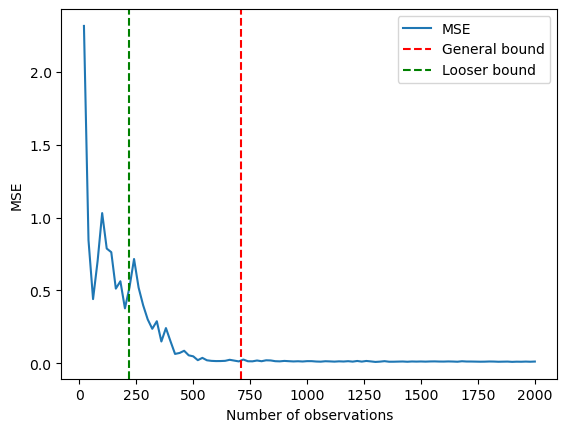

In [11]:
# Plot the results
plt.plot(num_observations, mse_over_num_obs, label="MSE")
plt.axvline(general_bound, color="red", linestyle="--", label="General bound")
plt.axvline(looser_bound, color="green", linestyle="--", label="Looser bound")
plt.xlabel("Number of observations")
plt.ylabel("MSE")
plt.legend()
plt.show()

### Forward selection

In [15]:
fs = ForwardSelection(fm_k4.T, fm_k4.y, fm_k4.k)

In [24]:
fs.forward_selection()

In [25]:
fs.selected_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]